# Intel N-DNS baseline inference using Lava

This is an example notebook demonstraring the inference of baseline Intel N-DNS network using lava. A baseline network for the challenge is proided with this repository here: `baseline_solution/sdnn_delays`. The lava processes and their interconnections to realize the baseline solution is shown below

![](https://user-images.githubusercontent.com/29907126/214492346-611b6adb-2aa1-4fac-936f-c22cc6fc1a47.png)


The baseline solution follows the challenge solution structure of
* Audio Source
* Encoder
* N-DNS network
* Decoder
* Audio Receiver

<!-- * **Encoder:** The encoder is a straightforward STFT transform of the noisy audio waveform followed by delta encoding of the STFT magnitude. The default STFT transform uses a window length of 512 with a hop length of 128, leading to 8ms per time-step. These parameters are user changeable. The delta encoding sparsifies the STFT magnitude which is then fed to the Neuromorphic DNS network.
* **N-DNS:** The neuromorphic DNS network is a three layer feedforward sigma-delta ReLU network with axonal delays. The sigma-delta layer efficiently performs denoising in the sparse domain. The axonal delays provide the network with short term memory which can be used to incorporate previous temporal patterns during denoising. The maximum value of axonal delays can be set by the user. It can even be set to 0 which means there is no axonal delay in the N-DNS network. The N-DNS network predicts a multiplicative mask at some delay which is then used to mask the STFT Magnitude. The prediction delay can also be changed, even set to zero, during training. The STFT phase and magnitude from the encoder need to be delayed accordingly during the decoding phase.
* **Decoder** The decoder combines the multiplicative mask predicted by the N-DNS network with the delayed STFT phase and magnitude of the noisy audio signal and performs inverse STFT with the same _window length_ and _hop length_ as the encoder. The resulting output is the clean reconstruction (denoised) audio waveform. -->

In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps

from audio_dataloader import DNSAudio
from snr import si_snr

from lava.magma.core.process.ports.ports import InPort, OutPort
from lava.magma.core.process.process import AbstractProcess
from lava.magma.core.run_configs import Loihi2HwCfg, Loihi2SimCfg
from lava.magma.core.run_conditions import RunSteps

from lava.lib.dl import netx

from lava_utils import (
    AudioSource, AudioReceiver,
    Encoder, Decoder,
    DelayBuffer,
    FloatPtAmp, FixedPtAmp, Bias, AmplitudeMixer,
    async_proc_model_map
)

## Load the parameters of the trained network

In [2]:
trained_folder = 'Trained'

args = yaml.safe_load(open(trained_folder + '/args.txt', 'rt'))
if 'out_delay' not in args.keys():
    args['out_delay'] = 0
if 'n_fft' not in args.keys():
    args['n_fft'] = 512
root = args['path']
out_delay = args['out_delay']
n_fft = args['n_fft']
win_length = n_fft
hop_length = n_fft // 4
stft_mean = 0.2
blank_time = 10
num_samples = 5

## Create Lava instance of N-DNS network

Since the baseline network was trained using lava-dl, the trained network gets exported as a `network.net` artifact which can be easily consumed by lava-dl NetX moudle to create a lava process representing the network.

<p align="center">
<img src="https://user-images.githubusercontent.com/29907126/214492443-fa3b3dce-1fdc-49cb-99f8-854aa3dfc84a.png" alt="Drawing" style="max-height: 300px;"/>
</p>


In [3]:
net = netx.hdf5.Network(trained_folder + '/network.net')

/workspace/k8mirror/lava-dl/src/lava/lib/dl/netx/hdf5.py:388: UserWarning: Found max delay of 64.0. Clamping the delays.
  warnings.warn(f'Found max delay of {delay.max()}.'


## Create Encoder

The encoder takes the noisy audio sequence and applies STFT to the sequence. The encoder is also responsible for data preprocessing of mean normalization of the STFT magnitude and scaling the floating point value to fixed point representation which is then fed to the N-DNS network.

<p align="center">
<img src="https://user-images.githubusercontent.com/29907126/214492521-eee98587-e229-4cdd-8c13-3278c5fc4d24.png" alt="Drawing" style="max-height: 300px;"/>
</p>


In [4]:
encoder = Encoder(n_fft=n_fft, hop_length=hop_length, bias=-stft_mean, gain=1 << 6)

## Create Decoder

The decoder takes the N-DNS network's raw output, rescales the fixed point representation of the network, interpretes the multiplicative mask, applies it to the STFT magnitue. The masked STFT magnitude is then combined with the initial STFT phase using an ISTFT module which produces the denoised auio stream.

<p align="center">
<img src="https://user-images.githubusercontent.com/29907126/214492627-9ac89a13-c537-4ef5-b9b4-bd910258815a.png" alt="Drawing" style="max-height: 300px;"/>
</p>


In [5]:
istft_delay = n_fft // hop_length - 1
decoder = Decoder(n_fft=n_fft, hop_length=hop_length,
                  gain=1 / (1 << 18), istft_delay=istft_delay)

## Create audio source and audio receivers

Create an audio source for the Intel N-DNS dataset and a receiver to collect the denoised audio from the N-DNS network. The audio receiver collects the audio and evaluates the SI-SNR metric for each samples. In addition, we also create a noisy audio receiver which serves as the baseline SI-SNR before denoising for comparison.

<p align="center">
<img src="https://user-images.githubusercontent.com/29907126/214480207-9306b935-a5d6-4d83-925b-b137fe754dc6.png" alt="Drawing" style="max-height: 300px;"/>
</p>


In [6]:
# train_set = DNSAudio(root=root + 'training_set/')
validation_set = DNSAudio(root=root + 'validation_set/')
noisy, clean, noise, metadata = validation_set[0]

interval = len(noisy) // hop_length + blank_time
audio_source = AudioSource(validation_set,
                           hop_length=hop_length,
                           interval=interval,
                           sample_idx=0)
denoised_receiver = AudioReceiver(hop_length=hop_length,
                                  num_samples=num_samples,
                                  interval=interval)
noisy_receiver = AudioReceiver(hop_length=hop_length,
                               num_samples=denoised_receiver.num_samples,
                               interval=interval)


## Create Delay blocks

The baseline solution needs delay units of 1 algorithmic timestep to synchronize the mangitude and phase calculation with the delay incurred by the N-DNS network.

In [7]:
abs_delay = DelayBuffer(shape=encoder.abs_out.shape, delay=1)
arg_delay = DelayBuffer(shape=encoder.abs_out.shape, delay=1)
clean_delay = DelayBuffer(shape=audio_source.clean_out.shape,
                          delay=1 + istft_delay)

## Connect the processes

In [8]:
audio_source.clean_out.connect(noisy_receiver.clean_inp)
audio_source.noisy_out.connect(noisy_receiver.denoised_inp)

encoder.enc_out.connect(net.in_layer.neuron.a_in)
net.out.connect(decoder.dec_inp)

encoder.abs_out.connect(abs_delay.inp)
abs_delay.out.connect(decoder.abs_inp)
encoder.arg_out.connect(arg_delay.inp)
arg_delay.out.connect(decoder.arg_inp)

audio_source.noisy_out.connect(encoder.audio_inp)
audio_source.clean_out.connect(clean_delay.inp)
clean_delay.out.connect(denoised_receiver.clean_inp)
decoder.audio_out.connect(denoised_receiver.denoised_inp)

## Run the network

In [9]:
# Customizations to enable async execution of the process models
from lava.magma.core.model.py.model import PyLoihiProcessModel, PyLoihiModelToPyAsyncModel
from lava.proc.sdn.process import Delta, SigmaDelta, Sigma
from lava.proc.sdn.models import PyDeltaModelFixed, PySigmaDeltaModelFixed, PySigmaModelFixed

exception_proc_map = {Delta: PyLoihiModelToPyAsyncModel(PyDeltaModelFixed),
                      SigmaDelta: PyLoihiModelToPyAsyncModel(PySigmaDeltaModelFixed),
                      Sigma: PyLoihiModelToPyAsyncModel(PySigmaModelFixed),
                      **async_proc_model_map}

In [10]:
num_samples = denoised_receiver.num_samples
num_steps = num_samples * (len(noisy) // hop_length + blank_time) + 1

print(f'{num_samples = }')
print(f'{num_steps = }')
# run_config = Loihi2SimCfg(select_tag='fixed_pt')
# run_config = AsyncSimCfg(select_tag='fixed_pt')
run_config = Loihi2SimCfg(exception_proc_model_map=exception_proc_map, select_tag='fixed_pt')
audio_source.run(condition=RunSteps(num_steps=num_steps), run_cfg=run_config)
si_snrs = denoised_receiver.si_snr.get()
base_si_snrs = noisy_receiver.si_snr.get()
audio_source.stop()

num_samples = 5
num_steps = 18801


## Compare denoising results

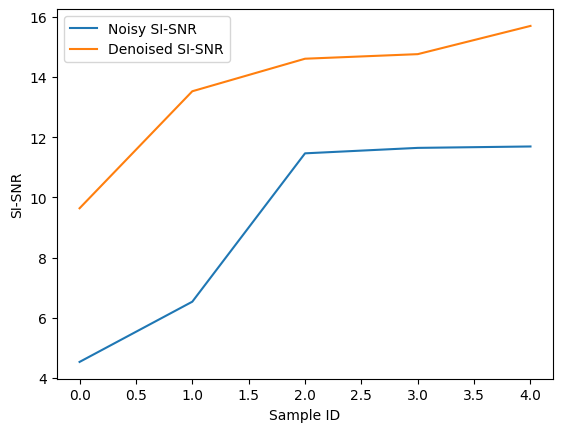

In [11]:
plt.plot(base_si_snrs, label='Noisy SI-SNR')
plt.plot(si_snrs, label='Denoised SI-SNR')
plt.xlabel('Sample ID')
plt.ylabel('SI-SNR')
plt.legend()